<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第四章：从头实现一个GPT模型用于生成文本

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.7.5
torch version: 2.5.1+cu121
tiktoken version: 0.8.0


- 本章实现一个GPT架构的模型，下一章则是聚焦在如何训练这个模型

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">
</p>

## 4.1 编写LLM架构
- 第一章中讨论了如GPT、Llama结构的模型，此类模型以序列的方式生成文本，是基于原始transformer架构中的decoder部分构建
- 因此，LLMs往往被称为仅编码器的LLMs
- 与传统的深度学习模型比较，LLMs更大，主要是参数量大，而不是实现代码多
- 可以在LLMs的架构中看到很多模块重复

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">
</p>

- 在之前的章节中，使用对输出、输出使用较小的嵌入层维度，便于进行解释用途
- 在本章中，将按照小型的GPT2模型的架构设置参数
- 将专门编写最小的 GPT-2 模型（1.24 亿参数）的架构，正如 Radford 等人在 [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 中所概述的那样（请注意，初始报告中列出的参数量是 1.17 亿，但在模型权重仓库中后来被更正）
- 第六章会展示如何加载本章节实现的LLMs模型的预训练参数如何加载，该实现将兼容 3.45 亿、7.62 亿和 15.42 亿参数的模型规模

- 1.24 亿参数的GPT2模型的详细配置参数如下

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 词表大小
    "context_length": 1024, # 支持的最长上下文长度，1K
    "emb_dim": 768,         # 嵌入层维度
    "n_heads": 12,          # 注意力头数
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout率
    "qkv_bias": False       # 是否使用偏置
}

- 以下使用简短的变量名以避免之后出现过长的代码行
- `"vocab_size"` 表示词汇量大小为50,257个词，这由第2章讨论的BPE分词器支持
- `"context_length"` 代表模型的最大输入标记数量，这由第2章介绍的位置嵌入实现
- `"emb_dim"` 是标记输入的嵌入大小，将每个输入标记转换为768维向量
- `"n_heads"` 是第3章实现的多头注意力机制中的注意力头数量
- `"n_layers"` 是模型内部transformer块的数量，将在接下来的章节中实现
- `"drop_rate"` 是第3章讨论的dropout机制的强度；0.1意味着在训练期间丢弃10%的隐藏单元以减轻过拟合
- `"qkv_bias"` 决定多头注意力机制（来自第3章）中的Linear层在计算查询(Q)、键(K)和值(V)张量时是否应包含偏置向量；将禁用此选项，这是现代LLM的标准做法；但是，在第5章将OpenAI的预训练GPT-2权重加载时，将重新讨论这一点

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="400px">
</p>

In [45]:
from typing import Dict, List

import torch
import torch.nn as nn
import tiktoken
import matplotlib.pyplot as plt

In [6]:
class DummyTransformerLayer(nn.Module):  # 实现的是一个身份变换层，输入什么就输出什么；可以起到占位符的作用
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        # 模拟一个transformer块的结构
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x
    

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 模拟一个layer norm层

    def forward(self, x):
        return x


class DummyGPTModel(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])
        
        # 先使用一个占位符类实现整体架构
        self.trf_blocks = nn.Sequential(*[DummyTransformerLayer(cfg) for _ in range(cfg["n_layers"])])

        # 使用一个占位符类实现layer norm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.shape
        tok_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.dropout(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp" width="400px">
</p>

In [8]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)  # 将列表堆叠为一个张量，即一个batch
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [9]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


---

**注意**

- 因为是在Linux系统上运行，故输出的结果如上，原作者在Mac上的输出结果如下：
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 是由于随机数导致的，不必担心，可以毫无问题地继续阅读本章的剩余部分
- 一个可能的原因是`nn.Dropout`在不同操作系统上的行为不同，这取决于PyTorch的编译方式，具体可以参考[这里](https://github.com/pytorch/pytorch/issues/121595)

---

## 4.2 带层归一化的正则化激活层
- 层归一化，也称为 LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450))，将神经网络层的激活值集中在平均值 0 左右，并将其方差归一化为 1
- 层归一化可以提高训练稳定性，加速收敛到有效权重
- 层归一化常用在带有多头注意力的transformer block之前或之后，后续会展示如何实现；其也会倍用在最终输出层之前

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">
</p>

- 以下展示如何通过将一个小的输入样本传递给简单神经网络层来理解层归一化

In [10]:
torch.manual_seed(123)

# 生成两个维度为5的训练样本
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 计算上述输出的均值和方差

In [11]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 归一化独立地应用于两个输入(行)中的每一个；使用dim=-1将计算应用于最后一个维度(在这种情况下是特征维度)，而不是行维度。

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">
</p>

- 减去均值并除以方差的平方根(标准差)将输入在列(特征)维度上居中，使其均值为0且方差为1。

In [13]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer output:\n", out_norm)

mean_norm = out_norm.mean(dim=-1, keepdim=True)
var_norm = out_norm.var(dim=-1, keepdim=True)
print("Normalized mean:\n", mean_norm)
print("Normalized variance:\n", var_norm)

Normalized layer output:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Normalized mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Normalized variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 每个输入都以0为中心，单位方差为1；为了提高可读性，可以禁用PyTorch的科学计数法表示。

In [14]:
torch.set_printoptions(sci_mode=False)
print("Normalized mean:\n", mean_norm)
print("Normalized variance:\n", var_norm)

Normalized mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Normalized variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 以上，对每个输入的特征进行了归一化
- 现在，使用相同的想法，实现一个LayerNorm类

In [28]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim: int) -> None:
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**scale和shift**

- 注意：上述实现LayerNorm类中，除了对输入进行先减去均值再除以方差的操作外，还加入了两个可训练参数，即`scale`和`shift`
- scale的初始值为1，shift的初始值为0，故开始时此两个参数对norm_x没有影响；但是，`scale`和`shift`是可训练参数，LLMs训练过程中这两个参数为自动更新，以得到更好的性能
- 这使得模型能够学习最适合其所处理数据的适当缩放和平移参数
- 请注意，在计算方差的平方根之前还添加了一个较小的值(eps)；这是为了避免在方差为0时出现除以零的错误

**有偏方差**
- 在上面的方差计算中，设置unbiased=False意味着使用公式 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 来计算方差，其中n是样本大小（在这里是特征数或列的数量）；这个公式不包含贝塞尔校正（在分母中使用n-1），因此提供的是方差的有偏估计
- 对于LLM模型，嵌入维度n非常大，使用n和n-1之间的差异可以忽略不计
- 然而，GPT-2在归一化层中使用的是有偏方差进行训练，这就是为什么此处采用这种设置，以便与在后续章节中加载的预训练权重兼容

- 现在实际尝试使用上述实现的LayerNorm类

In [29]:
ln = LayerNorm(5)
out_ln = ln(batch_example)

In [30]:
mean_ln = out_ln.mean(dim=-1, keepdim=True)
var_ln = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean_ln)
print("Variance:\n", var_ln)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">
</p>

## 4.3 实现带有GELU激活函数的前向网络

- 本小节实现一个小型神经网络子模块，其作为LLMs中transformer block的一部分
- 从激活函数开始
- 在深度学习中，ReLU（修正线性单元）激活函数因其简单性和在各种神经网络架构中的有效性而被广泛使用
- 在LLM中，除了传统的ReLU之外，还使用了各种其他类型的激活函数；两个值得注意的例子是GELU（高斯误差线性单元）和SwiGLU（Swish门控线性单元）
- GELU和SwiGLU是更复杂、更平滑的激活函数，分别融合了高斯和sigmoid门控线性单元，与ReLU更简单的分段线性函数不同，它们为深度学习模型提供了更好的性能

- GELU([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))可以通过几种方式实现；确切的版本定义为GELU(x)=x⋅Φ(x)，其中Φ(x)是标准高斯分布的累积分布函数。
- 在实践中，通常实现一个计算成本更低的近似公式：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$（原始GPT-2模型也是使用这种近似方法训练的）

In [40]:
class GELU(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x**3)))

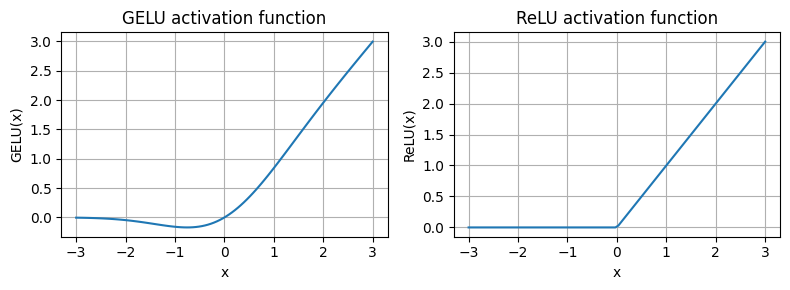

In [41]:
gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 如上图所示，ReLU是一个分段函数，如果输入为正，则直接输出输入；否则，输出为零
- GELU是一个平滑的非线性函数，它近似于ReLU，但对于负值有非零梯度（除了在约-0.75处）

- 接下来，实现一个小型神经网络模块FeedForward，后续将在LLM的transformer块中使用它

In [42]:
class FeedForward(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [43]:
print(GPT_CONFIG_124M["emb_dim"])

768


<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">
</p>

In [44]:
ffn = FeedForward(GPT_CONFIG_124M)

# 输入的shape为[batch_size, num_tokens, emb_dim]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">
</p>

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">
</p>

## 4.4 加一个残差连接

- 接下来，讨论一下快捷连接（shortcut connections）的概念，也称为跳跃连接或残差连接
- 最初，残差连接是在计算机视觉的深度网络（残差网络）中提出的，用于缓解梯度消失问题
- 残差连接为梯度创建了一条替代的更短路径，使其能够流经网络
- 这是通过将一层的输出添加到后面一层的输出来实现的，通常跳过中间的一层或多层
- 用一个小型示例网络来说明这个想法

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">
</p>

- 实际代码实现如下

In [46]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes: List[int], use_shortcut: bool = False) -> None:
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            # 计算当前层的输出
            layer_out = layer(x)
            # 检查是否应用残差连接
            if self.use_shortcut and layer_out.shape == x.shape:
                x = x + layer_out
            else:
                x = layer_out
        return x


def print_gradients(model, x):
    # 前向计算
    output = model(x)
    target = torch.tensor([[0.]])

    # 计算损失
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 反向传播计算梯度
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 打印权重的平均绝对梯度
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 先打印不使用残差连接的网络的梯度

In [47]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- 再打印使用残差连接的网络的梯度

In [48]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


- 如上所示，残差连接可以避免早期layers中出现梯度消失的问题，如未使用残差连接的layer.0的梯度为0.0002，而使用残差连接的layer.0的梯度为0.22
- 在实现transformer block时会使用残差连接的概念

## 4.5 在transformer块中连接注意力层和线性层

- 本小节将前面的概念组合成一个所谓的transformer block
- transformer block将上一章的因果多头注意力模块与线性层以及在前面章节实现的前馈神经网络相结合
- 此外，transformer block还使用了dropout和快捷连接

In [49]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 注意力模块设置残差连接
        shortcut = x
        x = self.norm1(x)  # 归一化
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 将原始输入添加回去

        # 线性层设置残差连接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 将原始输入添加回去

        return x

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">
</p>

- 假设有2个输入样本，每个样本包含6个token，其中每个token是一个768维的嵌入向量；那么这个transformer块应用自注意力机制，然后是线性层，以产生相似大小的输出
- 可以将输出视为在上一章中讨论的上下文向量的增强版本

In [50]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">
</p>

## 4.6 构建GPT模型

- 目前已经几乎完成了所有模块，将transformer block插入到本章开始实现的架构中就可以获得一个可用的GPT结构模型
- 注意，transformer块会重复多次；对于最小的124M GPT-2模型，重复了12次

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">
</p>      

In [55]:
class GPTModel(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.shape
        x = self.tok_emb(x) + self.pos_emb(torch.arange(seq_len, device=x.device))  # [batch_size, seq_len, emb_dim]
        x = self.drop(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        

- 使用124M参数模型的配置，现在可以如下所示用随机初始权重实例化这个GPT模型

In [54]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


- 将在下一章训练这个模型
- 然而，关于它的大小有一个简短说明：将其称为124M参数模型的原因是其大致有124M个参数，可以按以下方式验证这个数字

In [56]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 如上所见，这个模型有163M参数，而不是124M参数；为什么？
- 在原始GPT-2论文中，研究人员应用了权重绑定，将token嵌入层（tok_emb）重用为输出层，即设置self.out_head.weight = self.tok_emb.weight
- token嵌入层将50,257维的独热编码输入token投影到768维的嵌入表示中
- 输出层将768维嵌入投影回50,257维表示，这样可以将它们转换回单词（下一节会有更多介绍）
- 因此，嵌入层和输出层具有相同数量的权重参数，可以从它们权重矩阵的形状看出这一点
- 然而，关于它的大小有一个简短说明：之前将其称为124M参数模型；可以按以下方式验证这个数字

In [57]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始GPT-2论文中，研究人员将token嵌入矩阵重用为输出矩阵
- 相应地，减去输出层的参数数量，会得到一个124M参数的模型

In [58]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 实践发现不使用权重绑定更容易训练模型，这就是为什么上述实现中没有实现它
- 然而，当我第5章加载预训练权重时，将重新讨论并应用这种权重绑定的想法
- 最后，可以按以下方式计算模型的内存需求，这可以作为有用的参考点

In [59]:
# 计算总字节数，假设每个参数为4字节
total_size_bytes = total_params * 4

# 转换为兆字节
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- 练习：可以尝试以下其他配置，这些配置在[GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C)论文中有提及。

    - **GPT2-small** (已实现的参数量 124M 模型的配置):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 生成文本

- 像上面实现的类GPT的LLM模型用于一次生成一个词的

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">
</p>

- 以下的generate_text_simple函数实现了贪婪解码，这是一种简单且快速的文本生成方法
- 在贪婪解码中，模型在每一步都选择概率最高的词（或token）作为其下一个输出（最高的logit对应最高的概率，所以技术上甚至不需要显式计算softmax函数）
- 下一章将实现一个更高级的generate_text函数
- 下图描述了GPT模型如何在给定输入上下文的情况下生成下一个词token

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="400px">
</p>

In [61]:
def generate_text_simple(model: nn.Module, idx: torch.Tensor, max_new_tokens: int, context_size: int) -> torch.Tensor:
    # idx是当前上下文中tokens对用的索引序列，(batch, n_tokens)
    for _ in range(max_new_tokens):
        
        # 如果上下文大小超过支持的大小，则裁剪当前上下文
        # 例如，如果LLM只支持5个token，而上下文大小为10
        # 则只使用最后5个token作为上下文
        idx_cond = idx[:, -context_size:]
        
        # 获取预测
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 只关注最后一个时间步
        # (batch, n_tokens, vocab_size) 变为 (batch, vocab_size)
        logits = logits[:, -1, :]  

        # 应用softmax以获取概率
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # 获取具有最高概率值的词汇表索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 将采样的token索引添加到序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 上面的generate_text_simple实现了一个迭代过程，它一次预测一个token

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="400px">
</p>

- 准备一个输入例子

In [62]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [63]:
model.eval() # 验证模式，关闭dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- 去除批次维度，将token ids转换回文本

In [64]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 注意，该模型未经训练；因此上面的输出文本是随机的
- 将在下一章训练这个模型

## 总结和收获

- 请查看[./gpt.py](./gpt.py)脚本，其是一个独立脚本，包含本notebook中实现的GPT模型
- 可以在[./exercise-solutions.ipynb](./exercise-solutions.ipynb)中找到练习解答